In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from func_preproc_climada import *
from constants import * 
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact



In [57]:
def make_fn(addlist,basename,sep="_",filetype=''):
    return sep.join(addlist)+sep+basename+filetype

def get_lat_lon_res(ds):
    '''Function to obtain the average lat and lon gridspacing from a dataset of a non regular model grid. '''
    lat = ds.coords['lat']
    lon = ds.coords['lon']
    difflat = lat - lat.shift(lat=1)
    latres = difflat.mean().to_numpy()
    difflon = lon - lon.shift(lon=1)
    lonres = difflon.mean().to_numpy()
    return latres, lonres

def mask_qt(ds,q,timeres='day',stack=True,pastname='historical',futname='ssp585',cutarea=1000000):
    '''Function taking a dateset as an input, and returning it with the values below the quantile q at each grid cell
       masked. The mask is computed for each gridcell for the past period. Fields for which less than cutarea is above the
       quantile are dropped'''
    if stack:
        U = ds.stack(real=("member",timeres))
        dim="real"
        
    else:
        U = ds
        dim = timeres
    Upast = U[pastname]
    Upast_qt = Upast.quantile(q,dim=dim)    
    U_mask = U.where(U>Upast_qt)
    latres, lonres = get_lat_lon_res(ds)
    gcarea = latres*lonres*100*100 #gridcell area approximated: 1 deg corresponds to 100km
    threshold = round(cutarea/gcarea)
    
    U_mask = U_mask.dropna(dim=dim,thresh=threshold) #keep fields for which at least X values are not NaN
    return U_mask.unstack().fillna(0)

def scale_qt(ds,q,timeres='day',stack=True,pastname='historical',futname='ssp585',cutarea=1000000):
    '''Same as mask_qt but scaling by the q quantile.'''
    if stack:
        U = ds.stack(real=("member",timeres))
        dim = "real"
    else:
        U = ds
        dim = timeres
    Upast = U[pastname]

    Upast_qt = Upast.quantile(q,dim=dim)
    U_mask = U.where(U>Upast_qt)
    U_scaled = (U_mask-Upast_qt)/Upast_qt
    latres, lonres = get_lat_lon_res(ds)
    gcarea = latres*lonres*100*100 #gridcell area approximated: 1 deg corresponds to 100km
    threshold = round(cutarea/gcarea)
    U_scaled = U_scaled.dropna(dim=dim,thresh=threshold) #keep fields for which at least X values are not NaN
    return U_scaled.unstack().fillna(0)

def set_centroids(da,stack=True,haztype='WS',timeres="day",plot=False):
    '''Function which takes a xarray.DataArray as an input and returns a climada.hazard object, with centroids corresponding to 
        latitude and longitude of the DataArray.'''
    
    da = da.reindex(lat=list(reversed(da.lat))) #need to invert latitude
    period = da.name
    lat = da.lat
    lon = da.lon
    
    #compute mean grid spacing (irregular model grid) and round it to 1 digit
    latreso, lonreso = get_lat_lon_res(da)
    latres = latreso.round(4)
    lonres = lonreso.round(4)
    
    #get bondaries and round to 1 digit
    min_lat=lat[0].to_numpy().round(4)
    max_lat=lat[-1].to_numpy().round(4)
    min_lon=lon[0].to_numpy().round(4)
    max_lon=lon[-1].to_numpy().round(4)
    
    print('Lat resolution original: '+str(-latreso)+' ,rounded: '+str(-latres)+'\nLon resolution original: '+str(lonreso)+' ,rounded: '+str(lonres))
    
    # number of points
    n_lat = len(da.lat)
    n_lon = len(da.lon)
    
    #stack first members and time resolution, and then latitutde and longitude to obtain the event matrix
    if stack:
        events = da.stack(events=("member",timeres)) #need to be of size n_ev * ncent = nmem*180 * ncent
        nmem = len(da["member"])
    else:
        events = da.rename({"day":"events"})
        nmem = 1
    evmat = events.stack(cent=("lat","lon"))
    #print('Evmat: '+str(evmat.shape))
    print('lat: '+str(n_lat)+', lon: '+str(n_lon))
    #nmon = len(da[res]) 
    n_ev = len(evmat["events"])
    
    #intiate Hazard object, using Centroids.from_pix_bounds
    haz = Hazard(haztype)
    left, bottom, right, top = min_lon, min_lat, max_lon, max_lat
    #scale with 1/2 res?
    xf_lat = min_lat - 0.5*latres
    xo_lon = min_lon - 0.5*lonres
    d_lat = latres
    d_lon = lonres
    #haz.centroids = Centroids.from_pnt_bounds((left, bottom, right, top), xyres) # default crs used
    #haz.centroids = Centroids.from_lat_lon(lat,lon)
    haz.centroids = Centroids.from_pix_bounds(xf_lat, xo_lon, d_lat, d_lon, n_lat, n_lon) # default crs used
    #print('Centroids shape: '+ str(haz.centroids.shape)+', size: '+str(haz.centroids.size))
    haz.intensity = sparse.csr_matrix(evmat)
    haz.units = 'm/s'
    ev_id = np.arange(n_ev, dtype=int)
    haz.event_id = ev_id
    #dayid = ["ID: "+str(ev_id[evid])+ "day: "+ str(day) for evid,day in enumerate(nmem*da.time.dt.strftime('%Y-%m-%d').to_series().to_list())]
    ev_names = events.coords["events"].to_numpy().tolist()
    haz.event_name = ev_names
    #haz.date = [721166]
    haz.orig = np.zeros(n_ev, bool)
    haz.frequency = np.ones(n_ev)/(nmem*30)
    haz.fraction = haz.intensity.copy()
    haz.fraction.data.fill(1)
    haz.centroids.set_meta_to_lat_lon()
    haz.centroids.set_geometry_points()
    haz.check()
    print('Check centroids borders:', haz.centroids.total_bounds)
    if plot:
        haz.centroids.plot()
    
    return haz

def imp_calc(modname,exp,impf_set,pathin,basename,qt=0.98,cut=1000000,if_id=0,timeres='day',pastname='historical',futname='ssp585',
             savename=None,savefiles={"haz":False,"impcsv":False,"impmat":False,"impds":False}):
    '''Function to compute impacts. Does not require already preprocessed fields. Return hazard and impact climada objects.'''  
    #read netcdf
    fn = pathin+modname+'_'+basename+".nc"
    ncdf = xr.open_dataset(fn)
    ncdfw = ncdf[[pastname,futname]]
    #apply gust factor
    gust_ds = gst_fact*ncdfw
    
    #get name of impact_func
    if_name = impf_set.get_func(haz_type=haz_type,fun_id=0).name
    
    #preprocess fields
    preprocess_func = pp_func_dic[if_name]
    gust_pp = preprocess_func(gust_ds,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=futname)
    gust_pp_past = gust_pp[pastname]
    gust_pp_fut = gust_pp[futname]
    
    #prepare hazards centroids
    haz_past = set_centroids(gust_pp_past,timeres=timeres)
    haz_fut = set_centroids(gust_pp_fut,timeres=timeres)
    
    # Exposures: rename column and assign id
    exp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
    exp.gdf['impf_' + haz_type] = if_id
    exp.check()
    exp.gdf.head()
    #deepcopy exposure before assigning centroids
    exp_past = cp.deepcopy(exp)
    exp_fut = cp.deepcopy(exp)
    
    #assign centroids
    exp_fut.assign_centroids(haz_fut,distance='euclidian')
    exp_past.assign_centroids(haz_past,distance='euclidian')
    
    
    #compute impacts
    #past
    start_time = timer()
    imp_past = Impact()
    imp_past.calc(exp_past, impf_set, haz_past, save_mat=True) #Do not save the results geographically resolved (only aggregate values)
    time_delta_past = timer() - start_time
    print(time_delta_past)
    #future
    start_time = timer()
    imp_fut = Impact()
    imp_fut.calc(exp_fut, impf_set, haz_fut, save_mat=True)
    time_delta_fut = timer() - start_time
    print(time_delta_fut)

    ##save files
    if savename:
        savenameb = savename
    else:
        savenameb = basename
    
    savename_past = 'hist_'+modname+'_'+savenameb
    savename_fut = 'ssp585_'+modname+'_'+savenameb
    impf_namesht = impf_sht_names[if_name]
    #save hazards
    if savefiles["haz"]:
        haz_past.write_hdf5('results/hazards/'+savename_past+'.h5')
        haz_fut.write_hdf5('results/hazards/'+savename_fut+'.h5')
    #save impacts
    if savefiles["impcsv"]:
        imp_past.write_csv('results/impacts/impact csv'+impf_namesht+"_"+savename_past+'.csv')
        imp_fut.write_csv('results/impacts/impact csv'+impf_namesht+"_"+savename_fut+'.csv')
        
    if savefiles["impmat"]:
        imp_past.write_sparse_csr('results/impacts/impact matrices/'+impf_namesht+"_"+savename_past+'.npz')
        imp_fut.write_sparse_csr('results/impacts/impact matrices/'+impf_namesht+"_"+savename_fut+'.npz')
        
    if savefiles["impds"]:
        imp_past.write_sparse_csr('results/impacts/impact matrices/'+impf_namesht+"_"+savename_past+'.npz')
        imp_fut.write_sparse_csr('results/impacts/impact matrices/'+impf_namesht+"_"+savename_fut+'.npz')

    return haz_past, haz_fut, imp_past, imp_fut

def imp_calc_hist_fut(res_df,res_df2,modname,exp,impf_set,basename,pathin,pathout,if_id=0,qt=0.98,cut=1000000,gst_fact=1.67,timeres='day'
                      ,pastname='historical',futname='ssp585',savefiles={"haz":False,"impcsv":False,"impmat":False},
                     savenamehaz=None,savenameimp=None):
    '''Function to compute impacts and compute some statistic, between historical and future periode. Return dataframe res_df containing
        AAI_agg, 45yrs and 90 yrs impacts for each period, model and impact function'''
    
    #read netcdf
    fn = pathin+modname+'_'+basename+".nc"
    ncdf = xr.open_dataset(fn)
    ncdfw = ncdf[[pastname,futname]]
    #apply gust factor
    gust_ds = gst_fact*ncdfw
    
    #get name of impact_func
    if_name = impf_set.get_func(haz_type=haz_type,fun_id=0).name
    
    #preprocess fields
    preprocess_func = pp_func_dic[if_name]

    gust_pp = preprocess_func(gust_ds,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=futname)
    gust_pp_past = gust_pp[pastname]
    gust_pp_fut = gust_pp[futname]
    
    #prepare hazards centroids
    haz_past = set_centroids(gust_pp_past,timeres=timeres)
    haz_fut = set_centroids(gust_pp_fut,timeres=timeres)
    
    # Exposures: rename column and assign id
    exp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
    exp.gdf['impf_' + haz_type] = if_id
    exp.check()
    #exp.gdf.head()
    #deepcopy exposure before assigning centroids
    exp_past = cp.deepcopy(exp)
    exp_fut = cp.deepcopy(exp)
    
    #assign centroids
    exp_fut.assign_centroids(haz_fut,distance='euclidian')
    exp_past.assign_centroids(haz_past,distance='euclidian')
    
    
    #compute impacts
    #past
    start_time = timer()
    imp_past = Impact()
    imp_past.calc(exp_past, impf_set, haz_past, save_mat=savefiles['impmat']) #Do not save the results geographically resolved (only aggregate values)
    time_delta_past = timer() - start_time
    print(time_delta_past)
    #future
    start_time = timer()
    imp_fut = Impact()
    imp_fut.calc(exp_fut, impf_set, haz_fut, save_mat=savefiles['impmat'])
    time_delta_fut = timer() - start_time
    print(time_delta_fut)
    #compute freq curves 
    imp45_past = imp_past.calc_freq_curve(return_per=45).impact 
    imp45_fut = imp_fut.calc_freq_curve(return_per=45).impact 
    imp90_past = imp_past.calc_freq_curve(return_per=90).impact 
    imp90_fut = imp_fut.calc_freq_curve(return_per=90).impact 
    #save results
    res_df.loc[modname,("AAI_agg","past",if_name)] = imp_past.aai_agg
    res_df.loc[modname,("AAI_agg","future",if_name)] = imp_fut.aai_agg
    res_df.loc[modname,("45 yr impact","past",if_name)] = imp45_past
    res_df.loc[modname,("45 yr impact","future",if_name)] = imp45_fut
    res_df.loc[modname,("90 yr impact","past",if_name)] = imp90_past
    res_df.loc[modname,("90 yr impact","future",if_name)] = imp90_fut
    
    #save results v2
    res_df2.loc[(modname,if_name),("AAI_agg","past")] = imp_past.aai_agg
    res_df2.loc[(modname,if_name),("AAI_agg","future")] = imp_fut.aai_agg
    res_df2.loc[(modname,if_name),("45 yr impact","past")] = imp45_past
    res_df2.loc[(modname,if_name),("45 yr impact","future")] = imp45_fut
    res_df2.loc[(modname,if_name),("90 yr impact","past")] = imp90_past
    res_df2.loc[(modname,if_name),("90 yr impact","future")] = imp90_fut
    
    ##save files
    proc_names = ["qt"+str(qt)[-2:],"cutarea"+str(cut),"gst1-67"]
    impf_namesht = impf_sht_names[if_name]
    pp_funcname = str(pp_func_dic[if_name]).split(" ")[1] 

    basename_proc = make_fn(proc_names,basename)
    
    #save hazards
    if savefiles["haz"]:
        if savenamehaz is None:
            savenamehaz = pp_funcname+'_'+basename_proc
            print('/!\ savenamehaz is None, saving under '+basename_proc)

        haz_past.write_hdf5(pathout+'/hazards/'+make_fn(['haz',pastname,modname],savenamehaz,filetype='.h5'))
        haz_fut.write_hdf5(pathout+'/hazards/'+make_fn(['haz',futname,modname],savenamehaz,filetype='.h5'))
    
    #save impacts
    if savenameimp is None:
            savenameimp = impf_namesht+'_'+basename_proc
            print('/!\ savenameimp is None, saving under '+savenameimp)
            
    if savefiles["impcsv"]:
        imp_past.write_csv(pathout+'/impacts/impact csv/'+make_fn(['imp',pastname,modname],savenameimp,filetype='.csv'))
        imp_fut.write_csv(pathout+'/impacts/impact csv/'+make_fn(['imp',futname,modname],savenameimp,filetype='.csv'))
        
    if savefiles["impmat"]:
        imp_past.write_csv(pathout+'/impacts/impact matrices/'+make_fn(['imp',pastname,modname],savenameimp,filetype='.npz'))
        imp_fut.write_csv(pathout+'/impacts/impact matrices/'+make_fn(['imp',futname,modname],savenameimp,filetype='.npz'))
       
    return 

def tune_impf(modname,impf,paramsfn):
    paramspath = './calibration/'+paramsfn
    param_df = pd.read_csv(paramspath)
    impfname = impf.name
    param = param_df.loc[modname,("scale factor AAI_agg",impfname)]
    impf.mdd = param*impf.mdd
    return

def evnamestr(arrayel):
        '''Transform multiindex (tuple) of event index to a string '''
        imem = arrayel[0]
        iday = arrayel[1]
        strout = "Member: "+str(imem)+", day id: "+str(iday)
        return strout
evnamestr = np.vectorize(evnamestr)

In [150]:
### constants
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
#dict for abbreviations of the cmip6 variables names
cmip6vars = {'sfcWindmax':'SWM','sfcWind':'SW','psl':'SLP'}
##preprocessing and objects constants
gst_fact = 1.67
qt = 0.98
cut=2E6
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

## model sets
modlist = ['CanESM5','CNRM-CM6-1','CNRM-ESM2-1','EC-Earth3-Veg','EC-Earth3','EC-Earth3-Veg-LR','IPSL-CM6A-LR','MIROC-ES2L',
           'UKESM1-0-LL','MRI-ESM2-0','FGOALS-g3','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR','KACE-1-0-G','HadGEM3-GC31-LL',
           'HadGEM3-GC31-MM'] #complete model list

modset1 = ['CanESM5','CNRM-CM6-1','CNRM-ESM2-1','EC-Earth3-Veg-LR','IPSL-CM6A-LR','MIROC-ES2L','UKESM1-0-LL','MRI-ESM2-0',
           'FGOALS-g3','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR','KACE-1-0-G','HadGEM3-GC31-LL','HadGEM3-GC31-MM'] # removed 2 EC-Earth

modset2 = ['CanESM5','CNRM-CM6-1','CNRM-ESM2-1','IPSL-CM6A-LR','UKESM1-0-LL','MRI-ESM2-0','FGOALS-g3','ACCESS-ESM1-5',
           'MIROC6','MPI-ESM1-2-LR','HadGEM3-GC31-LL','HadGEM3-GC31-MM'] # remove models with unrealistic sfcWind patterns

modset3 = ['CNRM-CM6-1','CNRM-ESM2-1','IPSL-CM6A-LR','UKESM1-0-LL','MRI-ESM2-0','FGOALS-g3','ACCESS-ESM1-5','MIROC6',
           'MPI-ESM1-2-LR','HadGEM3-GC31-LL','HadGEM3-GC31-MM'] # additionally remove CanESM5 


##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt98pst","cutarea2E6","gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)

#calibration
caltype = "AAI_EU"
calfn = make_fn(["cal",caltype],basenamemet_proc,filetype=".csv")

#name climada output files
expres = 600 #in arcsecs
expname = 'exp'+str(expres)
hazname = 'haz_'+basenamemet
impname = 'imp_'+basenamemet

##paths and files names
pathin = '/home/lseverino/MT/cmip6/' #path of the cmip6 data
pathinvar = '/home/lseverino/MT/cmip6/'+selvar+'/' 
calpath = "/home/lseverino/MT/scripts/calibration/"
pathout = "/home/lseverino/MT/scripts/results/"
savefigpath = pathout+'figures/'


In [37]:
#cell to test ncdf imports and preprocess
modname = 'ACCESS-ESM1-5'
#fn = pathinvar+modname+'_'+basenamemet+".nc"
fn = make_fn(['long',modname],basenamemet,filetype=".nc")
ncdf1 = xr.open_dataset(pathinvar+fn)
ncdf_past = ncdf1['historical']
ncdf_qt = ncdf_past.quantile(qt,dim=("day","member"))
haz = set_centroids(ncdf_past,timeres="day")
#haz.plot_rp_intensity(smooth=False)

KeyboardInterrupt: 

/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<GeoAxesSubplot:title={'center':'Event ID 120000: (21, 10339)'}>

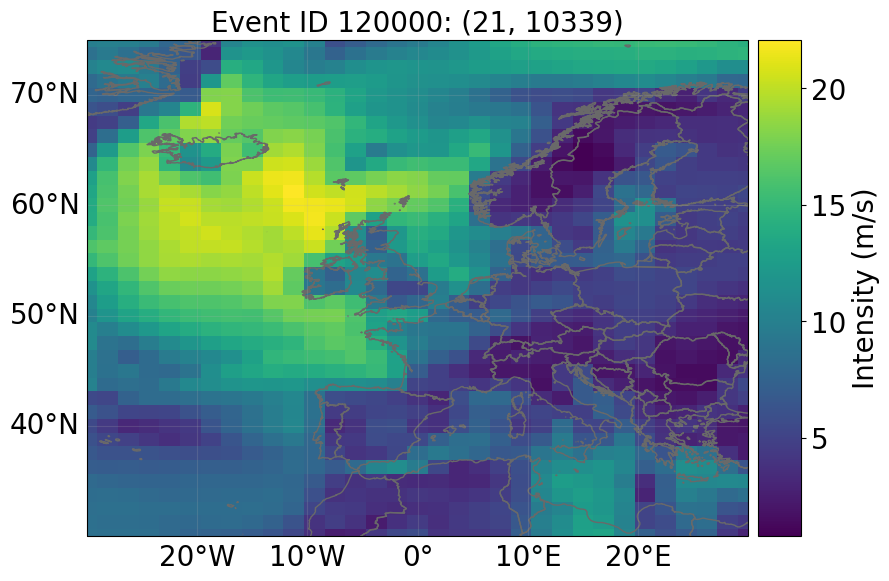

In [124]:
haz.plot_intensity(event=120000,smooth=False)

# Exposure

In [4]:
#import exposure data (already preprocessed)
from climada.entity import Exposures
from climada import CONFIG
results = CONFIG.local_data.save_dir.dir()
exp = Exposures.from_hdf5(results.joinpath(('exposures/exp_crpd_EU_600.h5')))
exp.check()


ax = exp.plot_hexbin(pop_name=False,vmin=1E7,vmax=1E11)
ax.set_title('LitPop Exposure for Europe, 2018',fontsize=15,fontweight="bold")
#plt.savefig(savefigpath+'/Exposures/hexbin_exp_cropped600EU.png',transparent=False)

In [5]:
# Implement impact function cubic excess from Prahl 2015 
from climada.entity import ImpactFunc
imp_fun = ImpactFunc()
imp_fun.haz_type = 'WS'
imp_fun.id = 0
imp_fun.name = 'Cubic excess-over-threshold'
# provide unit of the hazard intensity
imp_fun.intensity_unit = 'm/s'
# provide values for the hazard intensity, mdd, and paa
#imp_fun.intensity = np.linspace(0, 100, num=1500)
#mdd = imp_fun.intensity**3
#mdd_capped = np.where(mdd>1,1,mdd)
#imp_fun.mdd = mdd_capped
imp_fun.intensity = np.linspace(0, 1, num=20)
imp_fun.mdd = imp_fun.intensity**3
imp_fun.intensity = np.append(imp_fun.intensity, [100])
imp_fun.mdd = np.append(imp_fun.mdd, [1])
imp_fun.paa = np.ones(imp_fun.intensity.shape)
# check if the all the attributes are set correctly
imp_fun.check()


2022-04-25 14:39:13,183 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


# Impact functions

In [6]:
## impact function
from climada.entity.impact_funcs import storm_europe, ImpfTropCyclone

# Here we generate the impact function for TC damage using the formula of Emanuel 2011
impFunc_welker = storm_europe.ImpfStormEurope.from_welker()
impFunc_emanuel_usa = ImpfTropCyclone.from_emanuel_usa()

# plot the impact function
impFunc_emanuel_usa.id = 0
impFunc_emanuel_usa.haz_type = 'WS'
impFunc_emanuel_usa.check()

impFunc_welker.id = 0
impFunc_welker.haz_type = 'WS'
impFunc_welker.check()

2022-04-25 14:39:14,360 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


2022-04-25 14:39:15,397 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-04-25 14:39:15,399 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-04-25 14:39:15,447 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-04-25 14:39:15,448 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-04-25 14:39:15,466 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


(0.0, 2.0)

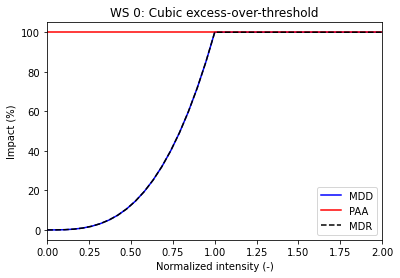

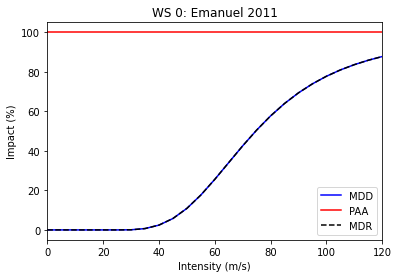

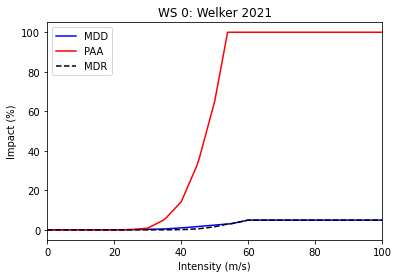

In [7]:
# generate 1 impf set per impact function 
from climada.entity import ImpactFuncSet
impf_list = [imp_fun,impFunc_emanuel_usa,impFunc_welker]
impf_namelist = []
impf_dict = dict()
axs=[]
for impf in impf_list:
    impfname = impf.name
    impf_namelist.append(impfname)
    impf_set = ImpactFuncSet()
    impf_set.append(impf)
    impf_set.check()
    ax = impf_set.plot()
    axs.append(ax)
    #plt.ylim((0,105))
    #plt.xlim((0,1))

    impf_dict[impfname] = impf_set
axs[0].set_xlabel('Normalized intensity (-)')
axs[0].set_xlim((0,2))

In [148]:
#dic to map each impact func to its preprocessing function
pp_func_dic = {'Cubic excess-over-threshold':scale_qt,'Emanuel 2011':mask_qt,'Welker 2021':mask_qt}
#dic for impf shortnames
impf_sht_names = {'Cubic excess-over-threshold':'CubEOT','Emanuel 2011':'Em2011','Welker 2021':'Wk2021'}

## Tuning of the impact functions

/home/lseverino/MT/scripts/calibration/cal_memsep_AAI_EU_qt98pst_cutarea2E6_gst1-67_SWM_br_rg_day_EU_winE.csv
ACCESS-ESM1-5
2022-04-25 16:11:32,440 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-04-25 16:11:32,440 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-04-25 16:11:32,441 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-04-25 16:11:32,441 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always nul

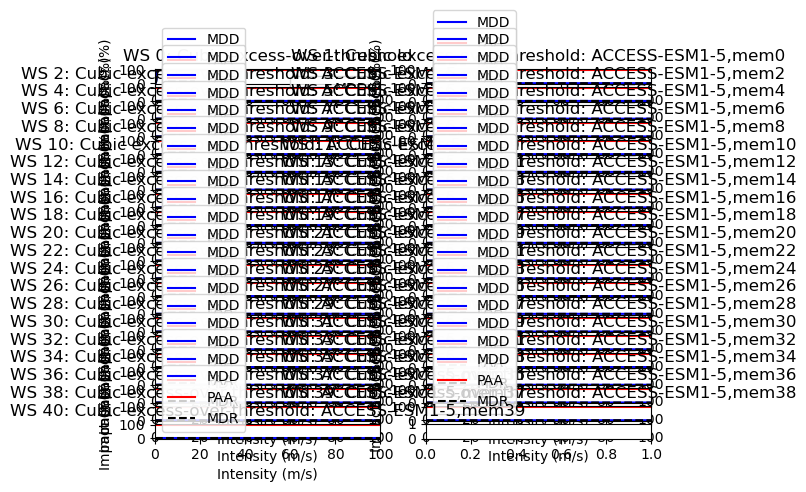

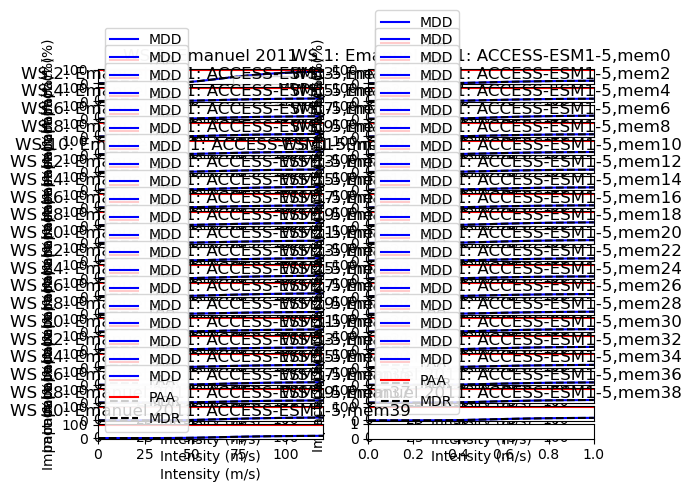

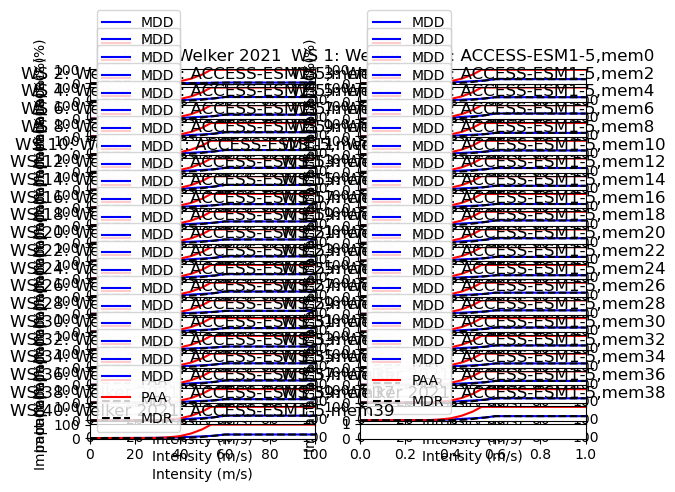

In [141]:
##run only if want to tune the impact function. Requires calibration csv file
paramspath = calpath+calfn
print(paramspath)
#prepare impact function set
for impf_name in impf_namelist:
    impf_set = impf_dict[impf_name]
    param_df = pd.read_csv(paramspath,header=[0,1,2],index_col=0)
    impf = impf_set.get_func(haz_type=haz_type,fun_id=0) #pick uncalibrated func with id=0
    nmems = len(param_df.index)
    for imem in range(nmems):
        new_impf = cp.deepcopy(impf)
        param = param_df.loc[imem,(mod,"scale factor AAI_agg",impf_name)]
        new_impf.mdd = param*new_impf.mdd
        new_impf.id = imem+1 #skip 0
        new_name = impf_name+': '+mod+',mem'+str(imem)
        new_impf.name = new_name
        impf_set.append(new_impf)
    impf_set.check()
    impf_set.plot()
    

In [38]:
#test cell to obtain hazard and impact climada objects
nmod = 0
modname = 'long_ACCESS-ESM1-5'
print(modname)
impf = 'Cubic excess-over-threshold'
impf_set = impf_dict[impf]
haz_past, haz_fut, imp_past, imp_fut = imp_calc(modname,exp,impf_set,pathinvar,basenamemet,timeres="day",if_id=0)

long_ACCESS-ESM1-5
Lat resolution original: 1.25 ,rounded: 1.25
Lon resolution original: 1.875 ,rounded: 1.875
lat: 37, lon: 33
Check centroids borders: (-30.9375, 29.375, 30.9375, 75.625)
Lat resolution original: 1.25 ,rounded: 1.25
Lon resolution original: 1.875 ,rounded: 1.875
lat: 37, lon: 33
Check centroids borders: (-30.9375, 29.375, 30.9375, 75.625)
93.27582453936338
108.13180498220026


<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (USD)'>

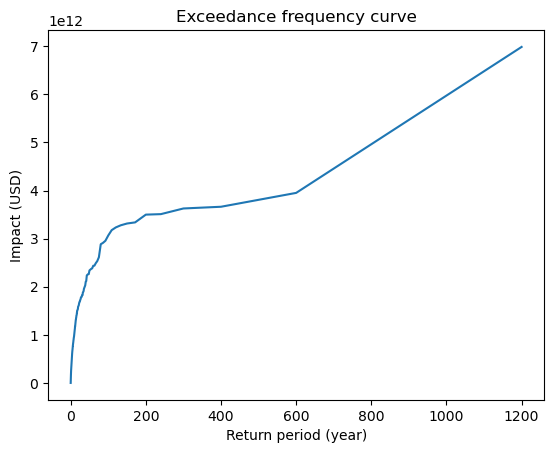

In [39]:
imp_fut.calc_freq_curve().plot()

<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (USD)'>

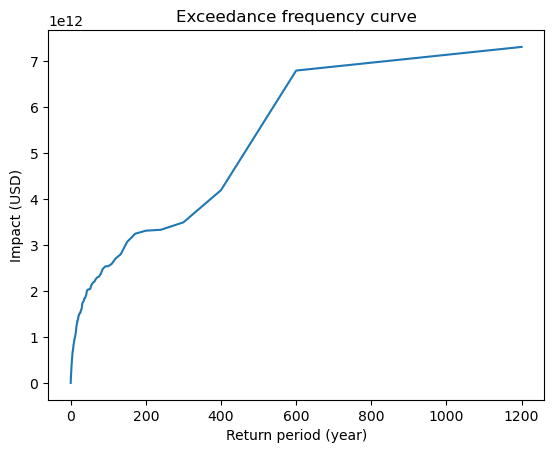

In [40]:
imp_past.calc_freq_curve().plot()

# Main calculation cell
1) iterate over the selected models
2) iterate over the selected impf
3) function call
    preprocess the fields
    compute impacts
    save


In [142]:
#initiate df to save results
colnames = ["AAI_agg","45 yr impact","90 yr impact"]
iterables = [modlist,colnames,["past","future"],impf_namelist]
col_idx = pd.MultiIndex.from_product(iterables,names=["model","metric","period","Impf"])
res_df = pd.DataFrame(columns=col_idx,index=modlist)  

#initiate df to save results v2
colnames = ["AAI_agg","45 yr impact","90 yr impact"]
iterablescol = [colnames,["past","future"]]
iterablesrows = [modlist,impf_namelist]

col_idx2 = pd.MultiIndex.from_product(iterablescol,names=["metric","period"])
row_idx2 = pd.MultiIndex.from_product(iterablesrows,names=["model","Impf"])
res_df2 = pd.DataFrame(columns=col_idx2,index=row_idx2)

In [48]:
impf_namelist

['Cubic excess-over-threshold', 'Emanuel 2011', 'Welker 2021']

In [153]:
#main calculation cell. Select impact functions to use from the available impact function in impf_namelist. Enable calibration
#using calibration=True. Specify name to save the files with savename.
calibration = False
savehaz = True
saveimpmat = True
saveimpcsv = True
if_id = 0
modlist = modlist
impf_used = impf_namelist
pastname = 'historical'
futname = 'ssp585'
timeres='day'

for modid, modname in enumerate(modlist):    
    #read netcdf
    fn = make_fn([modname],basenamemet,filetype=".nc")
    ncdf = xr.open_dataset(pathinvar+fn)
    ncdfw = ncdf[[pastname,futname]]
    #apply gust factor
    gust_ds = gst_fact*ncdfw
    nmems = len(gust_ds['member'])
    
    #initiate df
    res_df = pd.DataFrame(columns=col_idx,index=range(nmems))  
    res_df.index.name="nmem"
    for impf in impf_used:
        impf_set = impf_dict[impf]
        pp_funcname = str(pp_func_dic[impf]).split(" ")[1] 
        impf_namesht = impf_sht_names[impf]
        if calibration:
            calname=caltype
        else: 
            calname = 'nocal'
        savenamehaz = make_fn([pp_funcname],basenamemet_proc)
        savenameimp = make_fn([impf_namesht,calname],basenamemet_proc)
        
        #get name of impact_func
        if_name = impf_set.get_func(haz_type=haz_type,fun_id=0).name
        
        #iterate over the members
        for nmem in range(nmems):
            if calibration:
                if_id = nmem+1
            #preprocess fields
            mem_da = gust_ds.sel(member=nmem)
        
            preprocess_func = pp_func_dic[if_name]
        
            gust_pp = preprocess_func(mem_da,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=futname,stack=False)
            gust_pp_past = gust_pp[pastname]
            gust_pp_fut = gust_pp[futname]
            
            #prepare hazards centroids
            haz_past = set_centroids(gust_pp_past,stack=False,timeres=timeres)
            haz_fut = set_centroids(gust_pp_fut,stack=False,timeres=timeres)
            
            # Exposures: rename column and assign id
            exp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
            exp.gdf['impf_' + haz_type] = if_id
            exp.check()
            #exp.gdf.head()
            #deepcopy exposure before assigning centroids
            exp_past = cp.deepcopy(exp)
            exp_fut = cp.deepcopy(exp)
            
            #assign centroids
            exp_fut.assign_centroids(haz_fut,distance='euclidian')
            exp_past.assign_centroids(haz_past,distance='euclidian')
            
            #compute impacts
            #past
            start_time = timer()
            imp_past = Impact()
            imp_past.calc(exp_past, impf_set, haz_past, save_mat=saveimpmat) #Do not save the results geographically resolved (only aggregate values)
            time_delta_past = timer() - start_time
            print(time_delta_past)
            #future
            start_time = timer()
            imp_fut = Impact()
            imp_fut.calc(exp_fut, impf_set, haz_fut, save_mat=saveimpmat)
            time_delta_fut = timer() - start_time
            print(time_delta_fut)
            #compute freq curves 
            imp45_past = imp_past.calc_freq_curve(return_per=45).impact 
            imp45_fut = imp_fut.calc_freq_curve(return_per=45).impact 
            imp90_past = imp_past.calc_freq_curve(return_per=90).impact 
            imp90_fut = imp_fut.calc_freq_curve(return_per=90).impact 

            #save results
            res_df.loc[nmem,(modname,"AAI_agg","past",if_name)] = imp_past.aai_agg
            res_df.loc[nmem,(modname,"AAI_agg","future",if_name)] = imp_fut.aai_agg
            res_df.loc[nmem,(modname,"45 yr impact","past",if_name)] = imp45_past
            res_df.loc[nmem,(modname,"45 yr impact","future",if_name)] = imp45_fut
            res_df.loc[nmem,(modname,"90 yr impact","past",if_name)] = imp90_past
            res_df.loc[nmem,(modname,"90 yr impact","future",if_name)] = imp90_fut
            
            ##save files
            proc_names = ["qt"+str(qt)[-2:],"cutarea"+str(cut),"gst1-67"]
            impf_namesht = impf_sht_names[if_name]
            pp_funcname = str(pp_func_dic[if_name]).split(" ")[1] 
        
            basename_proc = make_fn(proc_names,basenamemet)
            
            #save hazards
            if savehaz:
                haz_past.write_hdf5(pathout+'/hazards/'+make_fn(['haz','nmem'+str(nmem),pastname,modname],savenamehaz,filetype='.h5'))
                haz_fut.write_hdf5(pathout+'/hazards/'+make_fn(['haz','nmem'+str(nmem),futname,modname],savenamehaz,filetype='.h5'))
            
            #save impacts
            if saveimpcsv:
                imp_past.write_csv(pathout+'/impacts/impact csv/'+make_fn(['imp','nmem'+str(nmem),pastname,modname],savenameimp,filetype='.csv'))
                imp_fut.write_csv(pathout+'/impacts/impact csv/'+make_fn(['imp','nmem'+str(nmem),futname,modname],savenameimp,filetype='.csv'))
                
            if saveimpmat:
                imp_past.write_csv(pathout+'/impacts/impact matrices/'+make_fn(['imp','nmem'+str(nmem),pastname,modname],savenameimp,filetype='.npz'))
                imp_fut.write_csv(pathout+'/impacts/impact matrices/'+make_fn(['imp','nmem'+str(nmem),futname,modname],savenameimp,filetype='.npz'))
               
            
res_df = res_df.astype(np.float64)


Lat resolution original: 2.7892999999999972 ,rounded: 2.7893
Lon resolution original: 2.8125 ,rounded: 2.8125
lat: 16, lon: 21
Check centroids borders: (-29.53125, 30.681449999999998, 29.53125, 75.31025)
Lat resolution original: 2.7892999999999972 ,rounded: 2.7893
Lon resolution original: 2.8125 ,rounded: 2.8125
lat: 16, lon: 21
Check centroids borders: (-29.53125, 30.681449999999998, 29.53125, 75.31025)
3.1094109900295734
1.1055634338408709
Lat resolution original: 2.7892999999999972 ,rounded: 2.7893
Lon resolution original: 2.8125 ,rounded: 2.8125
lat: 16, lon: 21
Check centroids borders: (-29.53125, 30.681449999999998, 29.53125, 75.31025)
Lat resolution original: 2.7892999999999972 ,rounded: 2.7893
Lon resolution original: 2.8125 ,rounded: 2.8125
lat: 16, lon: 21
Check centroids borders: (-29.53125, 30.681449999999998, 29.53125, 75.31025)
2.801814680919051
1.1862834934145212
Lat resolution original: 2.7892999999999972 ,rounded: 2.7893
Lon resolution original: 2.8125 ,rounded: 2.8125

## Plots

<Figure size 640x480 with 0 Axes>

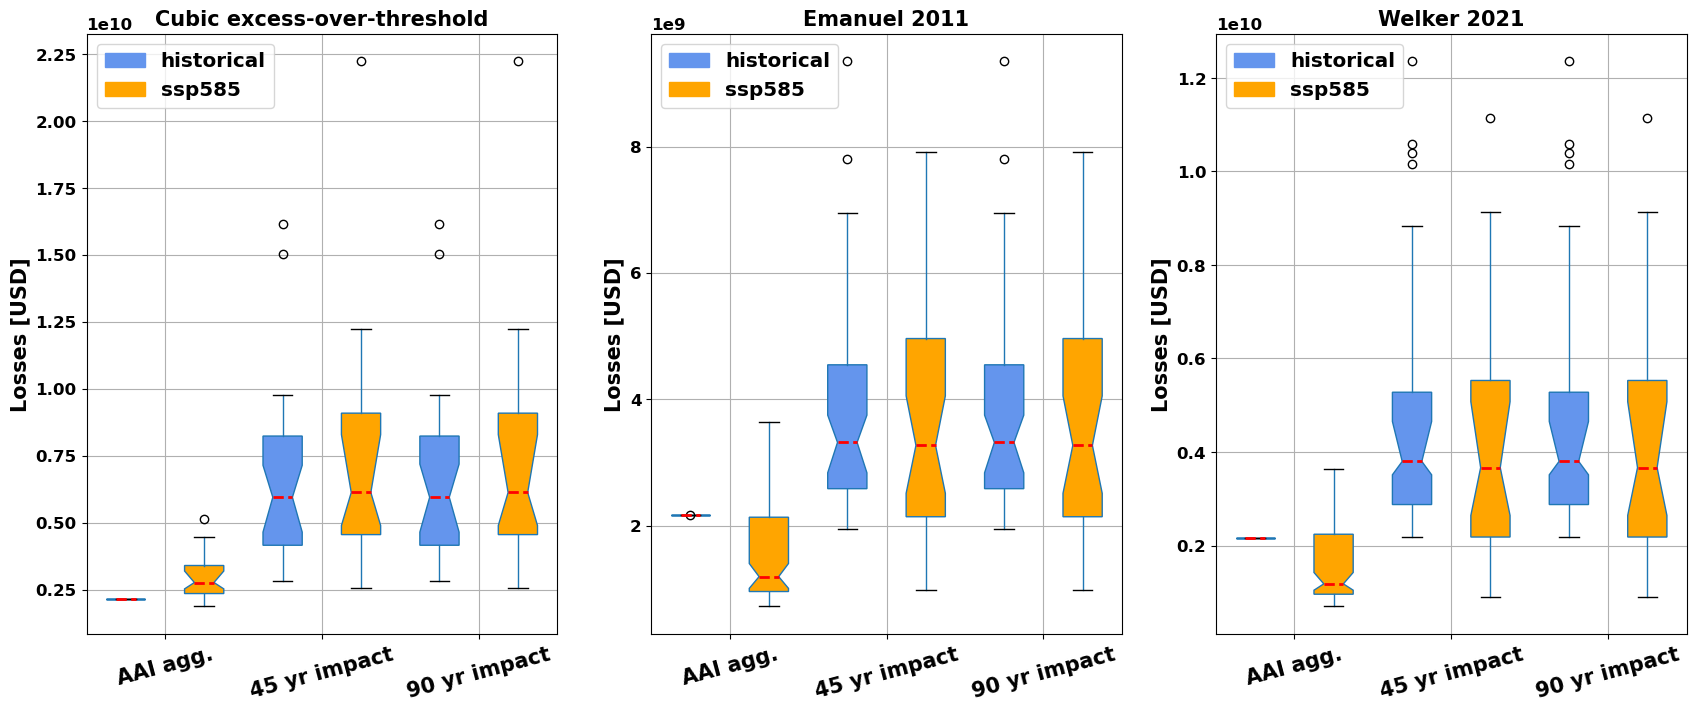

In [149]:
import matplotlib.patches as mpatches
labels = ['AAI agg. past ', 'AAI agg. future', '45 yr impact past',
       '45 yr impact future', '90 yr impact past', '90 yr impact future']
plt.figure()
plt.rcParams.update({'font.weight': 'bold'})
boxplots = res_df.groupby(axis=1,by="Impf").boxplot(figsize=(20,8),rot=15, labels=labels, patch_artist=True,subplots=True,
                                                    layout=(1,3),return_type='both',sharey=False,notch=True,bootstrap=10000)

for impi in boxplots.keys():
    axes = boxplots[impi].ax
    boxdict = boxplots[impi].lines
    plt.setp(boxdict['medians'], color='red',linewidth=2,linestyle='--',label='median')
    #[patch.set(facecolor='pink') for ip, patch in enumerate(boxdict['boxes']) if (ip+1)%2==0 ]
    for ip, patch in enumerate(boxdict['boxes']):
        if (ip+1)%2==0: 
            patch.set(facecolor='orange')
        else: 
            patch.set(facecolor='cornflowerblue')
    axes.set_xticklabels(labels,fontsize=10,fontweight='bold')
    axes.title.set_fontweight('bold')
    newpos = (1.5,3.5,5.5)
    axes.set_xticks(newpos,labels=['AAI agg.', '45 yr impact', '90 yr impact'],fontsize=15,fontweight='bold')
    #axes.set_xticklabels(labels+labels,fontsize=10,fontweight='bold')
    axes.title.set_fontweight('bold')
    axes.yaxis.get_offset_text().set_fontsize(12)
    axes.yaxis.get_offset_text().set_fontweight('bold')
    past_patch = mpatches.Patch(color='cornflowerblue', label='historical')
    fut_patch = mpatches.Patch(color='orange', label='ssp585')
    axes.legend(handles=[past_patch,fut_patch],loc='upper left',fontsize='x-large')
    #plt.title('Future vs past impact metrics distribution, all impact functions',fontsize=20,fontweight='bold')
    axes.set_ylabel("Losses [USD]",fontsize=15,fontweight='bold')
    axes.tick_params(axis='y', labelsize=12)
    plt.yticks(fontweight='bold',fontsize=12)
    axes.title.set_size(15)
#axes.set_yticklabels(axes.get_yticklabels(),fontweight='bold')
#ylabels = axes.get_yticklabels()
#[label.get_yticklabels() for label in ylabels]
savname = savefigpath+'Impacts/boxplots_impacts_hist-ssp585.png'
#plt.savefig(savename,transparent=False)
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Calibration
Type 1 calibration: do a modelwise calibration by scaling AAI_agg from the historical run on the yearly average impact from EMDAT.

##calibration: compute constant so that AAI_agg for the past simulation is ~to the AAI_agg from EMDAT
#initiate df to save results. Run only if the csv file has not already been created
param_names = ["scale factor AAI_agg"]
#if_ids = impf_set.get_ids()[haz_type]
#impf_names = [impf_set.get_func(haz_type=haz_type,fun_id = 1).name]
impf_names = impf_namelist
iterables1 = [modlist,param_names,impf_names]
col_idx = pd.MultiIndex.from_product(iterables1,names=["model","param name","Impf name"])
param_df = pd.DataFrame(columns=col_idx,index=res_df.index)
param_df.index.name = "nmems"
calfn = make_fn(['cal','memsep',caltype],basenamemet_proc,filetype=".csv")
param_df.to_csv(calpath+calfn)

In [130]:
modlist

['ACCESS-ESM1-5']

##open param csv
#to be run when res_df has been created, with uncalibrated impact functions
param_df = pd.read_csv(calpath+calfn,header=[0,1,2],index_col=0)

#select func to be calibrated
calfuncs = impf_used[2]
model = modlist[0]
#
idx = pd.IndexSlice

colnames = ["AAI_agg models"]
iterables2 = [modlist,colnames,impf_names]
col_idx2 = pd.MultiIndex.from_product(iterables2,names=["model","metric","Impf"])
aai_agg_models =pd.DataFrame(columns=col_idx2,index=res_df.index)
#aai_agg_models = res_df.loc[:,idx["AAI_agg","past",calfuncs]].copy()

aai_agg_models.loc[:,idx[:,:,calfuncs]] = res_df.loc[:,idx[model,"AAI_agg","past",calfuncs]]
#aai_agg_models.loc[:,(modlist,"AAI_agg models",calfuncs)] = res_df.loc[:,idx[:,"AAI_agg","past",calfuncs]]

ndaysp = 5468
nyrs = 30
aai_agg_emdat = 1000*2165734.375
param_df.loc[:,idx[:,:,calfuncs]] = aai_agg_emdat
param_df.loc[:,idx[:,:,calfuncs]] = param_df.loc[:,idx[:,:,calfuncs]].div(aai_agg_models.loc[:,idx[:,:,calfuncs]],axis=0)

#savename = impf_names[0].replace(' ','_')
param_df.to_csv(calpath+calfn)